# Weekly data analysis

Phase 1 conclusion was that regime-switching volatility explains the fat tails, making Student-t unnecessary. The natural next scientific question is: "If discrete volatility regimes work so well, will a continuous, dynamic volatility model (Stochastic Volatility) work even better?".
Adding Student-t didn't change anything because the volatility model already did the work.
Let's see how a Stochastic Volatility model can track market risk over time.

## Data preparation

/var/folders/kv/zt7j48t16bxdjlpfww8l32t00000gn/T/ipykernel_36976/4098304095.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start="2005-01-01", end="2025-01-01", interval="1wk")
[*********************100%***********************]  1 of 1 completed


Data Shape: (1043, 1)
Start Date: 2005-01-08 00:00:00
End Date:   2024-12-28 00:00:00


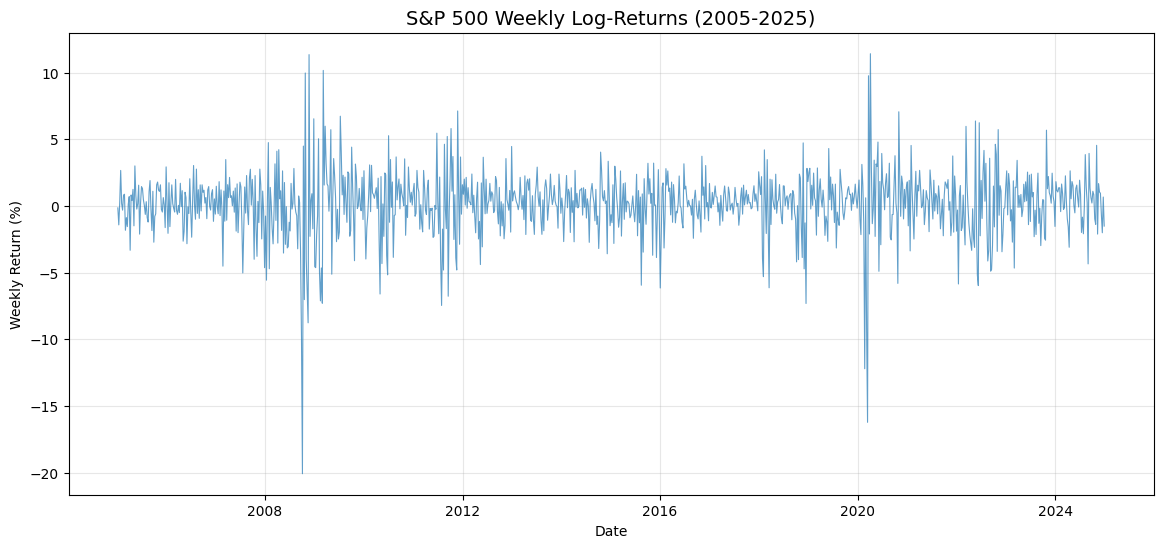

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# 1. Download Data (S&P 500 ETF or Index)
# ^GSPC is the S&P 500 index
print("Downloading S&P 500 data (2005-2025)...")
data = yf.download("^GSPC", start="2005-01-01", end="2025-01-01", interval="1wk")

# 2. Preprocessing
# Use 'Adj Close' if available, otherwise 'Close'
price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
prices = data[price_col]

# Calculate Log Returns
# r_t = ln(P_t / P_{t-1})
returns = np.log(prices / prices.shift(1)).dropna()

# Remove zero returns (rare artifacts in weekly data that can mess up log-vol)
returns = returns[returns != 0]

# We multiply by 100 to work with percentages, which is numerically more stable for PyMC
# Also, in Financial Time Series / Stochastic Volatility models, multiplying by 100 
# (converting to percentages) is actually the standard convention (it has a physical meaning).
returns_scaled = returns * 100

print(f"\nData Shape: {returns_scaled.shape}")
print(f"Start Date: {returns_scaled.index[0]}")
print(f"End Date:   {returns_scaled.index[-1]}")

# 3. Visualization
plt.figure(figsize=(14, 6))
plt.plot(returns_scaled, alpha=0.7, lw=0.8)
plt.title("S&P 500 Weekly Log-Returns (2005-2025)", fontsize=14)
plt.ylabel("Weekly Return (%)")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.show()

# Prepare for PyMC
y = returns_scaled.values
dates = returns_scaled.index

## Stochastic volatility model

In [4]:
import pymc as pm
import arviz as az

print(f"\nBuilding Stochastic Volatility Model for {len(y)} observations...")

with pm.Model() as model_sv:
    # 1. Volatility of Volatility
    sigma_h = pm.Exponential("sigma_h", 5.0)

    # 2. Latent Log-Volatility Process (Non-Centered)
    # KEY CHANGE: We separate the shape (Normal(0,1)) from the scale (sigma_h)
    # This makes the geometry "round" and easy for NUTS to sample
    h_innovations_raw = pm.Normal("h_innovations_raw", 0, 1, shape=len(y)-1)
    
    # Re-scale locally (deterministic transformation)
    h_innovations = pm.Deterministic("h_innovations", h_innovations_raw * sigma_h)

    # Reconstruct the Random Walk
    h_init = pm.Normal("h_init", mu=np.log(np.std(y)), sigma=0.5)
    h = pm.Deterministic("h", pm.math.concatenate([
        [h_init], 
        h_init + pm.math.cumsum(h_innovations)
    ]))

    # Transform to actual scale
    volatility = pm.Deterministic("volatility", pm.math.exp(h))

    # 3. Degrees of Freedom 
    nu = pm.Gamma("nu", alpha=2, beta=0.1)

    # 4. Likelihood
    obs = pm.StudentT("obs", nu=nu, mu=0, sigma=volatility, observed=y)

    print("Sampling... (Should be much faster)")
    # We can also slightly lower draws if you just want a quick look
    trace_sv = pm.sample(
        draws=1000, 
        tune=1000, 
        target_accept=0.9, # Non-centered often needs less aggressive target_accept
        chains=4,
        random_seed=42
    )


Initializing NUTS using jitter+adapt_diag...



Building Stochastic Volatility Model for 1043 observations...
Sampling... (Should be much faster)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_h, h_innovations_raw, h_init, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1733 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


## Post-fitting analysis

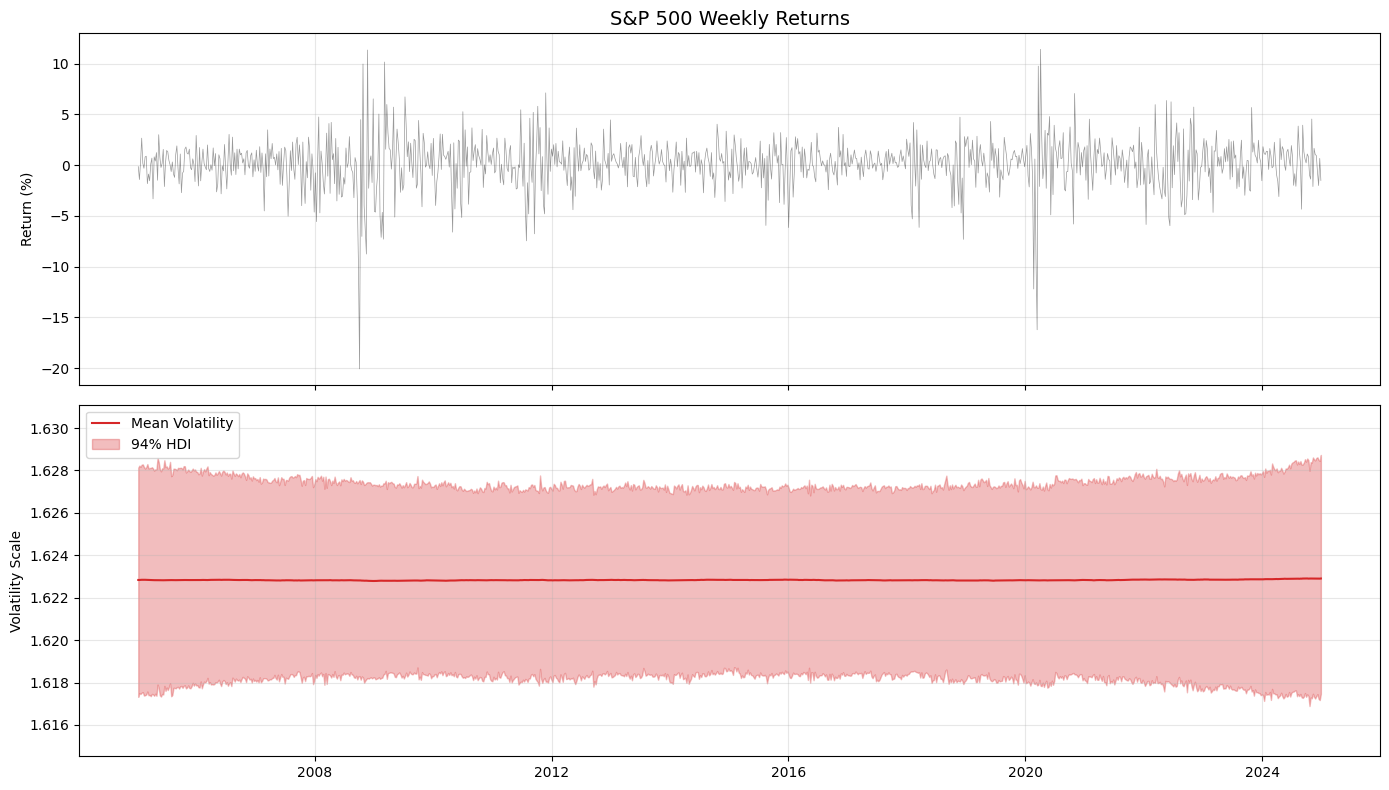

In [8]:
# Extract data
vol_mean = trace_sv.posterior["volatility"].mean(dim=["chain", "draw"]).values
hdi_vol = az.hdi(trace_sv.posterior)["volatility"].values

# Calculate bounds for adaptive zooming
hdi_min = hdi_vol.min()
hdi_max = hdi_vol.max()
# Add 20% padding around the min/max to ensure visibility
y_lower = max(0, hdi_min - (hdi_max - hdi_min)*0.2) 
y_upper = hdi_max + (hdi_max - hdi_min)*0.2

# Handle the "Flat Line" edge case (prevent crash if min == max)
if y_upper == y_lower:
    y_lower = hdi_min * 0.9
    y_upper = hdi_max * 1.1

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top Panel
ax[0].plot(dates, y, color="black", alpha=0.4, lw=0.5)
ax[0].set_title("S&P 500 Weekly Returns", fontsize=14)
ax[0].grid(True, alpha=0.3)
ax[0].set_ylabel("Return (%)")

# Bottom Panel
ax[1].plot(dates, vol_mean, color="#D62728", lw=1.5, label="Mean Volatility")
ax[1].fill_between(dates, hdi_vol[:, 0], hdi_vol[:, 1], color="#D62728", alpha=0.3, label="94% HDI")

# APPLY THE ADAPTIVE LIMITS
ax[1].set_ylim(y_lower, y_upper)

# Annotations (Optional)
ax[1].set_ylabel("Volatility Scale")
ax[1].legend(loc="upper left")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The estimated volatility is a flat line. This means the model failed to learn any time-varying volatility, effectively collapsing into a simple Student-t distribution with constant variance.
In the non-centered model, sigma_h acts as a multiplier. If it shrinks to zero, h_innovations get zeroed out, and the random walk becomes a flat line.
We need to change the prior on sigma_h (volatility of volatility) to strictly enforce that "volatility must change." The Exponential prior allows values too close to zero.
Better yet, for financial data, a HalfNormal(0.2) prior is often used for weekly log-volatility changes.

## Change Priors

In [ ]:
with pm.Model() as model_sv_fixed:
    # 1. Volatility of Volatility (Changed Prior!)
    # HalfNormal(0.2) should prevent it from shrinking to zero too easily 
    # while keeping it realistic for weekly data.
    sigma_h = pm.HalfNormal("sigma_h", sigma=0.2)

    # 2. Latent Log-Volatility (Non-Centered)
    h_innovations_raw = pm.Normal("h_innovations_raw", 0, 1, shape=len(y)-1)
    h_innovations = pm.Deterministic("h_innovations", h_innovations_raw * sigma_h)

    # Initial state
    h_init = pm.Normal("h_init", mu=np.log(np.std(y)), sigma=0.2)
    
    # Random Walk
    h = pm.Deterministic("h", pm.math.concatenate([
        [h_init], 
        h_init + pm.math.cumsum(h_innovations)
    ]))

    # 3. Degrees of Freedom
    nu = pm.Gamma("nu", alpha=2, beta=0.1)

    # 4. Likelihood
    volatility = pm.Deterministic("volatility", pm.math.exp(h))
    obs = pm.StudentT("obs", nu=nu, mu=0, sigma=volatility, observed=y)

    print("Sampling Fixed Model...")
    trace_sv = pm.sample(2000, tune=1000, target_accept=0.95, chains=4, random_seed=42)

Initializing NUTS using jitter+adapt_diag...


Sampling Fixed Model...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_h, h_innovations_raw, h_init, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2581 seconds.


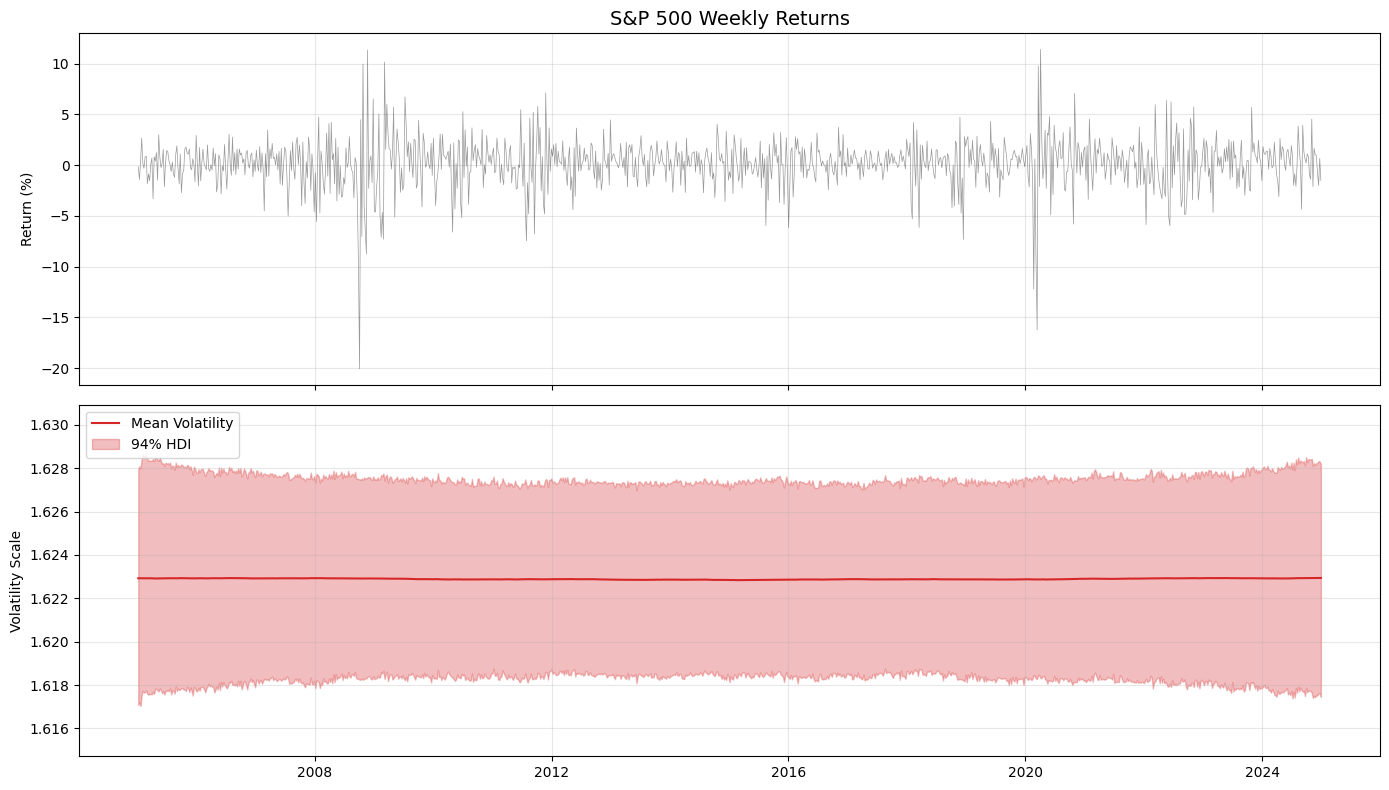

In [10]:
# Extract data
vol_mean = trace_sv.posterior["volatility"].mean(dim=["chain", "draw"]).values
hdi_vol = az.hdi(trace_sv.posterior)["volatility"].values

# Calculate bounds for adaptive zooming
hdi_min = hdi_vol.min()
hdi_max = hdi_vol.max()
# Add 20% padding around the min/max to ensure visibility
y_lower = max(0, hdi_min - (hdi_max - hdi_min)*0.2) 
y_upper = hdi_max + (hdi_max - hdi_min)*0.2

# Handle the "Flat Line" edge case (prevent crash if min == max)
if y_upper == y_lower:
    y_lower = hdi_min * 0.9
    y_upper = hdi_max * 1.1

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top Panel
ax[0].plot(dates, y, color="black", alpha=0.4, lw=0.5)
ax[0].set_title("S&P 500 Weekly Returns", fontsize=14)
ax[0].grid(True, alpha=0.3)
ax[0].set_ylabel("Return (%)")

# Bottom Panel
ax[1].plot(dates, vol_mean, color="#D62728", lw=1.5, label="Mean Volatility")
ax[1].fill_between(dates, hdi_vol[:, 0], hdi_vol[:, 1], color="#D62728", alpha=0.3, label="94% HDI")

# APPLY THE ADAPTIVE LIMITS
ax[1].set_ylim(y_lower, y_upper)

# Annotations (Optional)
ax[1].set_ylabel("Volatility Scale")
ax[1].legend(loc="upper left")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## New prior: gamma

In [11]:
import pymc as pm

print("Running Final Fixed Model (Gamma Prior)...")

with pm.Model() as model_sv_gamma:
    # --- CRITICAL FIX ---
    # Gamma(2, 5) has zero probability at 0. 
    # This forces the model to learn a dynamic volatility.
    sigma_h = pm.Gamma("sigma_h", alpha=2, beta=5)

    # Latent Log-Volatility (Non-Centered)
    h_innovations_raw = pm.Normal("h_innovations_raw", 0, 1, shape=len(y)-1)
    h_innovations = pm.Deterministic("h_innovations", h_innovations_raw * sigma_h)

    # Initial state
    h_init = pm.Normal("h_init", mu=np.log(np.std(y)), sigma=0.2)
    
    # Random Walk
    h = pm.Deterministic("h", pm.math.concatenate([
        [h_init], 
        h_init + pm.math.cumsum(h_innovations)
    ]))

    # Degrees of Freedom
    nu = pm.Gamma("nu", alpha=2, beta=0.1)

    # Likelihood
    volatility = pm.Deterministic("volatility", pm.math.exp(h))
    obs = pm.StudentT("obs", nu=nu, mu=0, sigma=volatility, observed=y)

    # Sampling
    trace_sv = pm.sample(2000, tune=1000, target_accept=0.95, chains=4, random_seed=42)


Running Final Fixed Model (Gamma Prior)...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_h, h_innovations_raw, h_init, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2877 seconds.


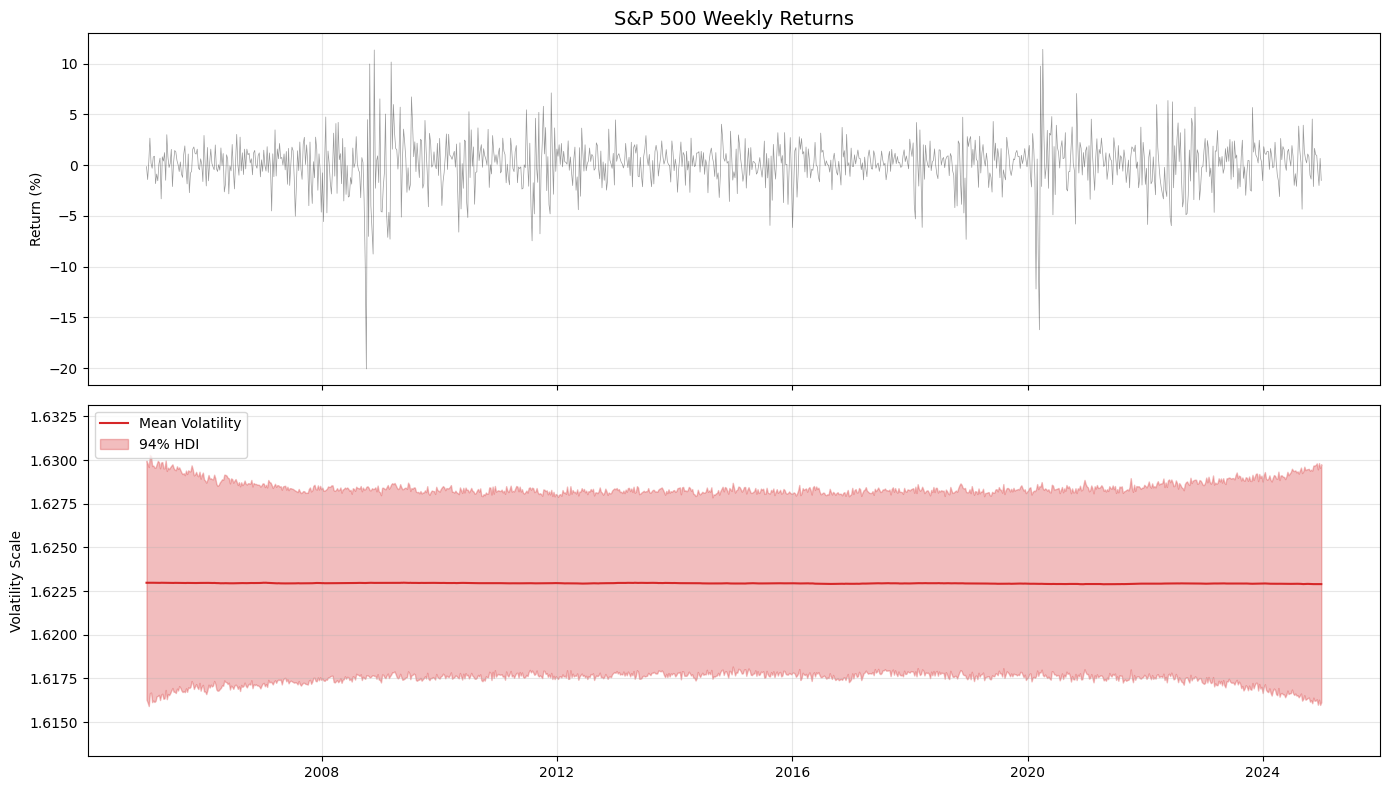

In [12]:
# Extract data
vol_mean = trace_sv.posterior["volatility"].mean(dim=["chain", "draw"]).values
hdi_vol = az.hdi(trace_sv.posterior)["volatility"].values

# Calculate bounds for adaptive zooming
hdi_min = hdi_vol.min()
hdi_max = hdi_vol.max()
# Add 20% padding around the min/max to ensure visibility
y_lower = max(0, hdi_min - (hdi_max - hdi_min)*0.2) 
y_upper = hdi_max + (hdi_max - hdi_min)*0.2

# Handle the "Flat Line" edge case (prevent crash if min == max)
if y_upper == y_lower:
    y_lower = hdi_min * 0.9
    y_upper = hdi_max * 1.1

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top Panel
ax[0].plot(dates, y, color="black", alpha=0.4, lw=0.5)
ax[0].set_title("S&P 500 Weekly Returns", fontsize=14)
ax[0].grid(True, alpha=0.3)
ax[0].set_ylabel("Return (%)")

# Bottom Panel
ax[1].plot(dates, vol_mean, color="#D62728", lw=1.5, label="Mean Volatility")
ax[1].fill_between(dates, hdi_vol[:, 0], hdi_vol[:, 1], color="#D62728", alpha=0.3, label="94% HDI")

# APPLY THE ADAPTIVE LIMITS
ax[1].set_ylim(y_lower, y_upper)

# Annotations (Optional)
ax[1].set_ylabel("Volatility Scale")
ax[1].legend(loc="upper left")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# AR1

## Baseline

In [4]:
import pymc as pm

print("Running Standard SV Model (AR1 process)...")

# 1. CENTER THE DATA
y_centered = y - np.mean(y)

# 2. BUILD THE MODEL (AR1 version, fixed phi)
with pm.Model() as model_ar1_fixed_phi:
    # Fix phi to a reasonable value (0.95 is standard for financial volatility)
    phi_fixed = 0.95
    
    # Priors for other parameters
    mu = pm.Normal("mu", mu=np.log(np.var(y_centered)), sigma=1.0)
    sigma_h = pm.HalfNormal("sigma_h", sigma=0.5)
    
    # AR(1) with FIXED phi
    h_centered = pm.AR(
        "h_centered",
        rho=phi_fixed,  # <-- FIXED, not random
        sigma=sigma_h,
        constant=False,
        ar_order=1,
        shape=len(y_centered),
        init_dist=pm.Normal.dist(0, sigma=1.0)
    )
    
    h = pm.Deterministic("h", h_centered + mu)
    volatility = pm.Deterministic("volatility", pm.math.exp(h / 2))
    
    # Normal likelihood
    obs = pm.Normal("obs", mu=0, sigma=volatility, observed=y_centered)
    
    print("Sampling with FIXED phi=0.95...")
    trace_ar1_fixed_phi = pm.sample(1000, tune=1000, target_accept=0.90, chains=4)



Running Standard SV Model (AR1 process)...
Sampling with FIXED phi=0.95...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_h, h_centered]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5041 seconds.
There were 308 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Plots

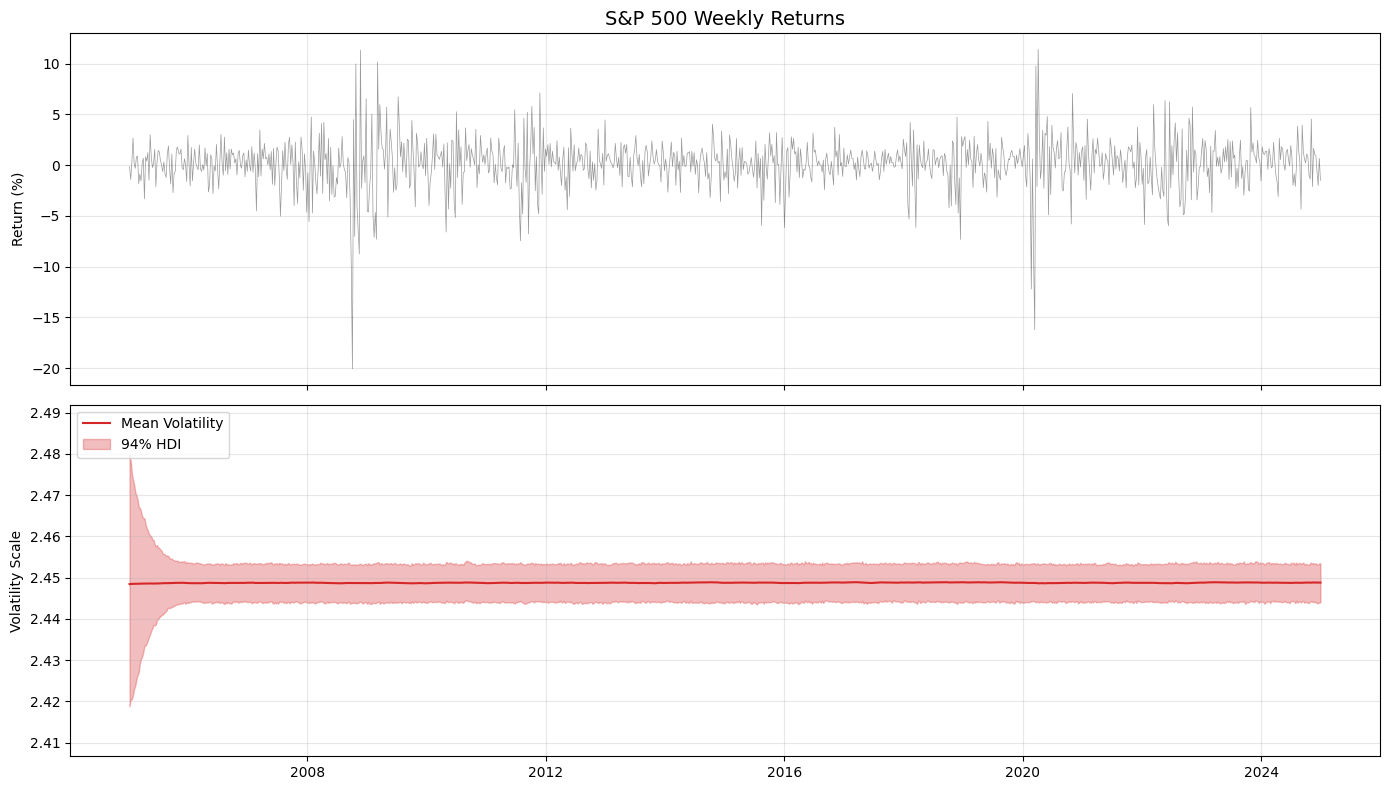

In [7]:
# Extract data
vol_mean_ar1 = trace_ar1_fixed_phi.posterior["volatility"].mean(dim=["chain", "draw"]).values
hdi_vol_ar1 = az.hdi(trace_ar1_fixed_phi.posterior)["volatility"].values


def plot_fit(vol_mean, hdi_vol):
    # Calculate bounds for adaptive zooming
    hdi_min = hdi_vol.min()
    hdi_max = hdi_vol.max()
    # Add 20% padding around the min/max to ensure visibility
    y_lower = max(0, hdi_min - (hdi_max - hdi_min)*0.2) 
    y_upper = hdi_max + (hdi_max - hdi_min)*0.2

    # Handle the "Flat Line" edge case (prevent crash if min == max)
    if y_upper == y_lower:
        y_lower = hdi_min * 0.9
        y_upper = hdi_max * 1.1

    fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Top Panel
    ax[0].plot(dates, y, color="black", alpha=0.4, lw=0.5)
    ax[0].set_title("S&P 500 Weekly Returns", fontsize=14)
    ax[0].grid(True, alpha=0.3)
    ax[0].set_ylabel("Return (%)")

    # Bottom Panel
    ax[1].plot(dates, vol_mean, color="#D62728", lw=1.5, label="Mean Volatility")
    ax[1].fill_between(dates, hdi_vol[:, 0], hdi_vol[:, 1], color="#D62728", alpha=0.3, label="94% HDI")

    # APPLY THE ADAPTIVE LIMITS
    ax[1].set_ylim(y_lower, y_upper)

    # Annotations (Optional)
    ax[1].set_ylabel("Volatility Scale")
    ax[1].legend(loc="upper left")
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_fit(vol_mean_ar1, hdi_vol_ar1)

Sampling GRW with Student-t...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_h, h_init, z, nu]


Output()

Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 1633 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


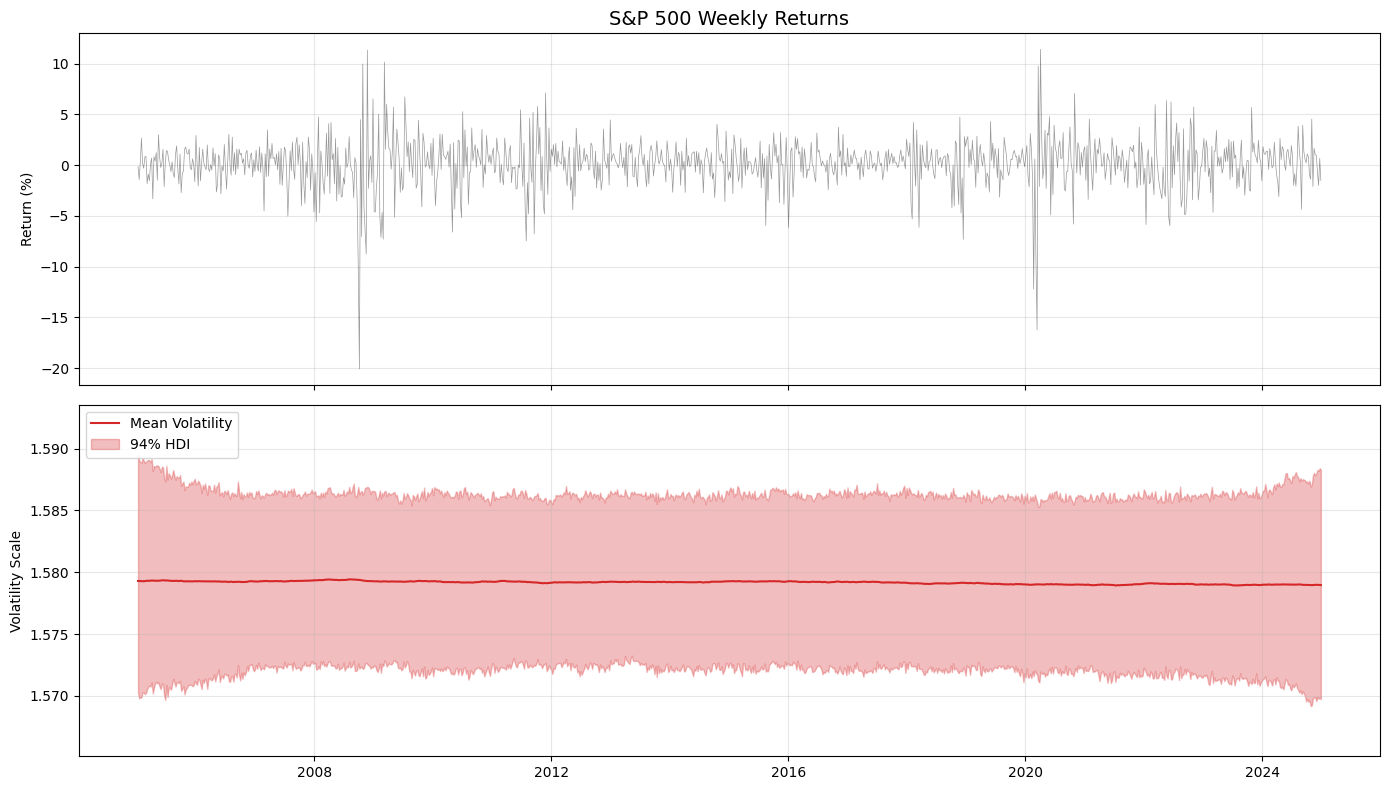

In [8]:
with pm.Model() as model_grw_strong:
    # VERY STRONG prior: Force sigma_h to be large enough for learning
    # We use a Gamma that concentrates mass between 0.1 and 0.5
    sigma_h = pm.Gamma("sigma_h", alpha=5, beta=10)  # Mean=0.5, SD=0.22
    
    # Initial log-volatility: Start higher than empirical to "break symmetry"
    h_init = pm.Normal("h_init", mu=np.log(np.std(y_centered)) + 0.5, sigma=0.3)
    
    # Non-centered parameterization
    z = pm.Normal("z", 0, 1, shape=len(y_centered)-1)
    h_innovations = z * sigma_h
    
    h = pm.Deterministic("h", pm.math.concatenate([
        [h_init],
        h_init + pm.math.cumsum(h_innovations)
    ]))
    
    # Volatility (log-volatility to volatility)
    volatility = pm.Deterministic("volatility", pm.math.exp(h / 2))
    
    # STUDENT-T likelihood (let's go straight to the final model)
    nu = pm.Exponential("nu", 1/10)
    obs = pm.StudentT("obs", nu=nu, mu=0, sigma=volatility, observed=y_centered)
    
    print("Sampling GRW with Student-t...")
    trace_grw = pm.sample(1500, tune=1000, target_accept=0.92, chains=2, cores=2)


# Extract data
vol_mean_grw = trace_grw.posterior["volatility"].mean(dim=["chain", "draw"]).values
hdi_vol_grw = az.hdi(trace_grw.posterior)["volatility"].values

plot_fit(vol_mean_grw, hdi_vol_grw)

# Volatility diagnostics

=== DEBUGGING ===
Type of y_centered: <class 'numpy.ndarray'>
Shape of y_centered: (1043, 1)
Type of dates: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Shape of dates: (1043,)

After flattening:
y_flat shape: (1043,)
dates_flat shape: (1043,)
Are they same length? True


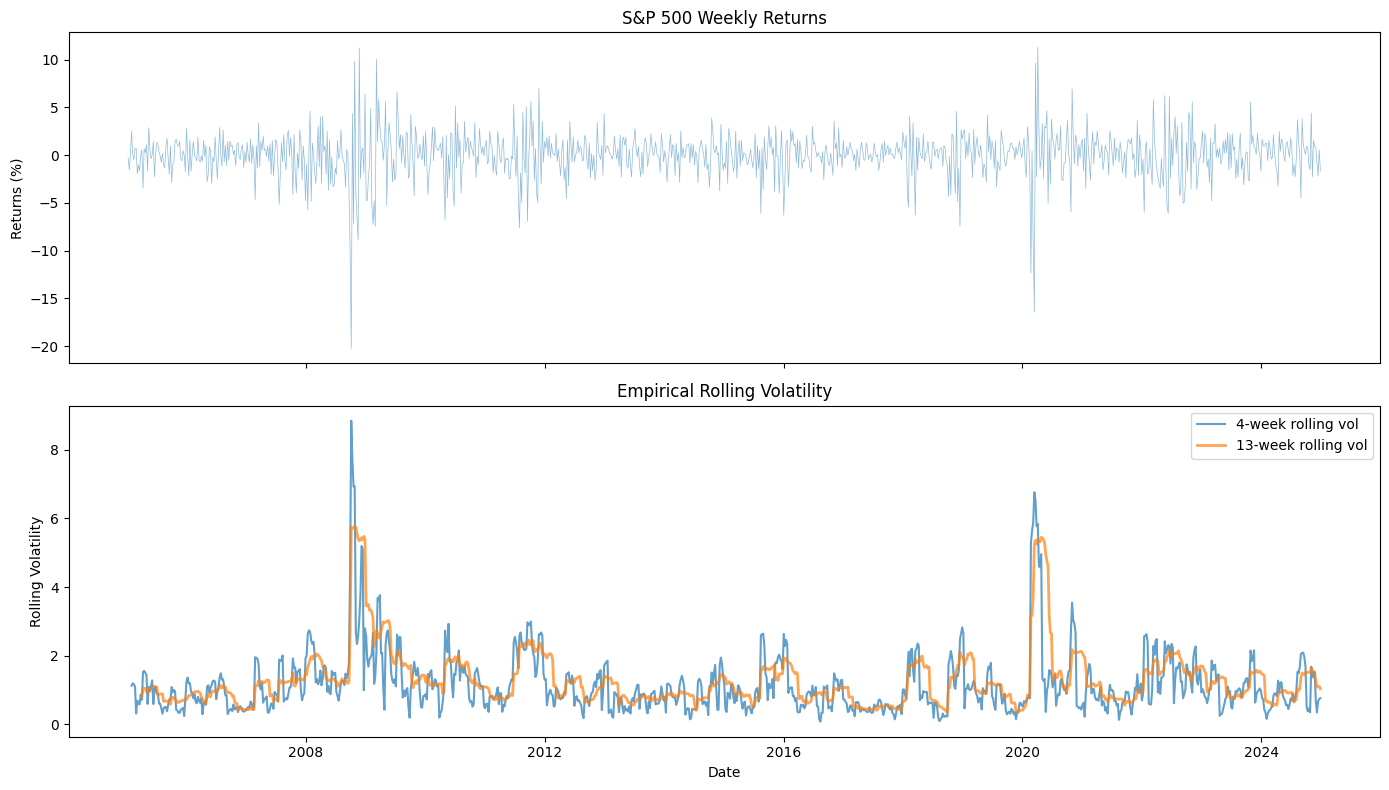


=== VOLATILITY CLUSTERING DIAGNOSTIC ===
Min rolling vol (13w): 0.349
Max rolling vol (13w): 5.775
Ratio (max/min): 16.57


In [13]:
# First, let's diagnose what we're working with
print("=== DEBUGGING ===")
print(f"Type of y_centered: {type(y_centered)}")
print(f"Shape of y_centered: {y_centered.shape if hasattr(y_centered, 'shape') else 'N/A'}")
print(f"Type of dates: {type(dates)}")
print(f"Shape of dates: {dates.shape if hasattr(dates, 'shape') else 'N/A'}")

# If dates is a pandas Index, we need to flatten it properly
if hasattr(dates, 'values'):
    dates_flat = dates.values.flatten()
else:
    dates_flat = np.array(dates).flatten()

# Ensure y_centered is also flat
y_flat = np.array(y_centered).flatten()

print(f"\nAfter flattening:")
print(f"y_flat shape: {y_flat.shape}")
print(f"dates_flat shape: {dates_flat.shape}")
print(f"Are they same length? {len(y_flat) == len(dates_flat)}")

# Now create DataFrame
df = pd.DataFrame({
    'return': y_flat, 
    'date': dates_flat
})

df['abs_return'] = np.abs(df['return'])
df['rolling_vol_4w'] = df['abs_return'].rolling(window=4).std()
df['rolling_vol_13w'] = df['abs_return'].rolling(window=13).std()

# Plot
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax[0].plot(df['date'], df['return'], alpha=0.5, lw=0.5)
ax[0].set_ylabel('Returns (%)')
ax[0].set_title('S&P 500 Weekly Returns')

ax[1].plot(df['date'], df['rolling_vol_4w'], label='4-week rolling vol', alpha=0.7)
ax[1].plot(df['date'], df['rolling_vol_13w'], label='13-week rolling vol', alpha=0.7, lw=2)
ax[1].set_ylabel('Rolling Volatility')
ax[1].set_xlabel('Date')
ax[1].legend()
ax[1].set_title('Empirical Rolling Volatility')
plt.tight_layout()
plt.show()

# Key statistics
print(f"\n=== VOLATILITY CLUSTERING DIAGNOSTIC ===")
print(f"Min rolling vol (13w): {df['rolling_vol_13w'].min():.3f}")
print(f"Max rolling vol (13w): {df['rolling_vol_13w'].max():.3f}")
print(f"Ratio (max/min): {df['rolling_vol_13w'].max() / df['rolling_vol_13w'].min():.2f}")


# Hierarchical regime switching model on daily data

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# Download FULL dataset (2007-2025)
print("Downloading S&P 500 data (2007-2025)...")
data_full = yf.download("^GSPC", start="2007-01-01", end="2025-01-01", interval="1d")

prices_full = data_full['Close']
returns_full = np.log(prices_full / prices_full.shift(1)).dropna() * 100
returns_full = returns_full[returns_full != 0]

# Split: Train (2007-2022), Test (2023-2025)
split_date = '2022-12-31'
returns_train = returns_full[:split_date]
returns_test = returns_full[split_date:]

# Center using ONLY training data statistics
train_mean = returns_train.mean()
train_std = returns_train.std()

y_train = (returns_train - train_mean).values
y_test = (returns_test - train_mean).values  # Use same centering!

dates_train = returns_train.index
dates_test = returns_test.index

print(f"\nTrain: {len(y_train)} days ({dates_train[0]} to {dates_train[-1]})")
print(f"Test:  {len(y_test)} days ({dates_test[0]} to {dates_test[-1]})")

# Compute realized volatility for both sets
realized_vol_train = returns_train.rolling(window=5).std().dropna()
realized_vol_test = returns_test.rolling(window=5).std().dropna()

log_vol_train = np.log(realized_vol_train.values)
log_vol_train_centered = log_vol_train - np.mean(log_vol_train)

log_vol_test = np.log(realized_vol_test.values)
log_vol_test_centered = log_vol_test - np.mean(log_vol_train)  # Use TRAIN mean!

dates_vol_train = realized_vol_train.index
dates_vol_test = realized_vol_test.index

/var/folders/kv/zt7j48t16bxdjlpfww8l32t00000gn/T/ipykernel_3772/2691770349.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_full = yf.download("^GSPC", start="2007-01-01", end="2025-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed


Train: 4027 days (2007-01-04 00:00:00 to 2022-12-30 00:00:00)
Test:  502 days (2023-01-03 00:00:00 to 2024-12-31 00:00:00)


In [2]:
import pymc as pm

# Define regimes based on TRAINING data threshold
threshold_train = realized_vol_train.quantile(0.90)
regime_train = (realized_vol_train[1:] > threshold_train).astype(int).values

with pm.Model() as hierarchical_train:
    # Same structure as before
    mu_normal = pm.Normal("mu_normal", mu=-0.5, sigma=1)
    phi_normal = pm.Beta("phi_normal", alpha=20, beta=2)
    sigma_normal = pm.HalfNormal("sigma_normal", sigma=0.3)
    
    mu_crisis = pm.Normal("mu_crisis", mu=0.5, sigma=1)
    phi_crisis = pm.Beta("phi_crisis", alpha=15, beta=3)
    sigma_crisis = pm.HalfNormal("sigma_crisis", sigma=0.5)
    
    mu_t = regime_train * mu_crisis + (1 - regime_train) * mu_normal
    phi_t = regime_train * phi_crisis + (1 - regime_train) * phi_normal
    sigma_t = regime_train * sigma_crisis + (1 - regime_train) * sigma_normal
    
    expected = mu_t + phi_t * log_vol_train_centered[:-1]
    
    nu = pm.Exponential("nu", 1/10)
    obs = pm.StudentT("obs", nu=nu, mu=expected, sigma=sigma_t, observed=log_vol_train_centered[1:])
    
    print("Fitting model on 2007-2022 data...")
    trace_train = pm.sample(3000, tune=1500, chains=4, target_accept=0.92)

Fitting model on 2007-2022 data...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_normal, phi_normal, sigma_normal, mu_crisis, phi_crisis, sigma_crisis, nu]


Output()

Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 42 seconds.


## Expanding window forecasting

Alignment Warning: Data len=498, Dates len=502
Truncating both to length 498 to prevent errors.
Forecasting 498 days using 12000 posterior samples...


/var/folders/kv/zt7j48t16bxdjlpfww8l32t00000gn/T/ipykernel_3772/591770213.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  threshold = float(realized_vol_train.quantile(0.90))
/var/folders/kv/zt7j48t16bxdjlpfww8l32t00000gn/T/ipykernel_3772/591770213.py:62: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  is_crisis = int(prev_realized_vol > threshold)


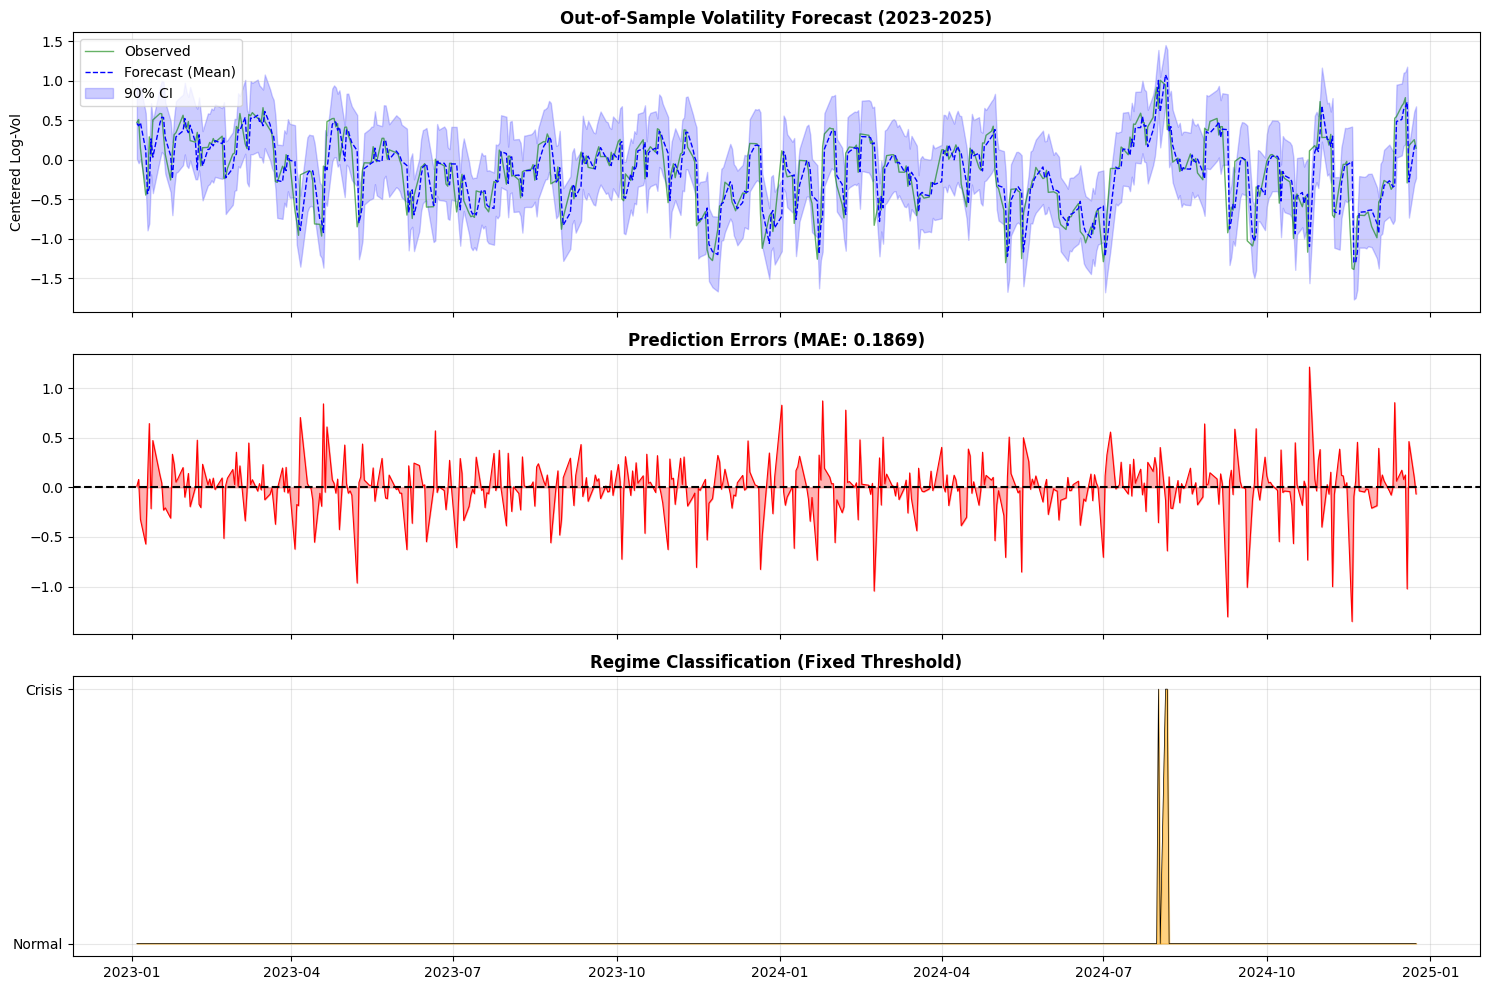

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def fixed_parameter_forecast(trace_train, log_vol_test, realized_vol_test, realized_vol_train, dates_test):
    """
    Forecasting using parameters learned from 2007-2022 (No Refitting).
    Includes automatic shape fixing and date alignment.
    """
    
    # --- 1. Fix Shapes & Alignments ---
    # Ensure inputs are 1D arrays
    log_vol_test = np.squeeze(log_vol_test)
    dates_test = np.array(dates_test)
    
    # Ensure lengths match exactly before starting
    min_len = min(len(log_vol_test), len(dates_test))
    if len(log_vol_test) != len(dates_test):
        print(f"Alignment Warning: Data len={len(log_vol_test)}, Dates len={len(dates_test)}")
        print(f"Truncating both to length {min_len} to prevent errors.")
        log_vol_test = log_vol_test[:min_len]
        dates_test = dates_test[:min_len]
        realized_vol_test = realized_vol_test.iloc[:min_len]
    
    n_test = len(log_vol_test)
    
    # --- 2. Extract Posterior Samples ---
    post = trace_train.posterior
    # Flatten chains
    mu_normal = post["mu_normal"].values.flatten()
    phi_normal = post["phi_normal"].values.flatten()
    sigma_normal = post["sigma_normal"].values.flatten()
    
    mu_crisis = post["mu_crisis"].values.flatten()
    phi_crisis = post["phi_crisis"].values.flatten()
    sigma_crisis = post["sigma_crisis"].values.flatten()
    
    nu = post["nu"].values.flatten()
    n_samples = len(mu_normal)

    # Threshold from training data
    threshold = float(realized_vol_train.quantile(0.90))
    
    # Storage
    forecasts_mean = np.zeros(n_test)
    forecasts_q05 = np.zeros(n_test)
    forecasts_q95 = np.zeros(n_test)
    regime_sequence = np.zeros(n_test)
    
    print(f"Forecasting {n_test} days using {n_samples} posterior samples...")
    
    # --- 3. Run Forecast Loop ---
    for t in range(n_test):
        if t == 0:
            continue # Skip first point (no lag available in this array)
            
        last_log_vol = log_vol_test[t-1]
            
        # Determine Regime (Using realized vol from t-1)
        prev_realized_vol = realized_vol_test.iloc[t-1]
        is_crisis = int(prev_realized_vol > threshold)
        regime_sequence[t] = is_crisis
        
        # Select parameters
        if is_crisis:
            mu, phi, sigma = mu_crisis, phi_crisis, sigma_crisis
        else:
            mu, phi, sigma = mu_normal, phi_normal, sigma_normal
            
        # Predictive Distribution
        expected_mu = mu + phi * last_log_vol
        preds = stats.t.rvs(df=nu, loc=expected_mu, scale=sigma, size=n_samples)
        
        forecasts_mean[t] = np.mean(preds)
        forecasts_q05[t] = np.percentile(preds, 5)
        forecasts_q95[t] = np.percentile(preds, 95)
        
    # --- 4. Return Aligned Results ---
    # Slice [1:] to remove the skipped first point
    return {
        'mean': forecasts_mean[1:],
        'q05': forecasts_q05[1:],
        'q95': forecasts_q95[1:],
        'observed': log_vol_test[1:],
        'regime': regime_sequence[1:],
        'dates': dates_test[1:]
    }

# ==========================================
# EXECUTE
# ==========================================

# Run the forecast
results_fast = fixed_parameter_forecast(
    trace_train, 
    log_vol_test_centered, 
    realized_vol_test,
    realized_vol_train,
    dates_test
)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# 1. Forecast vs Observed
axes[0].plot(results_fast['dates'], results_fast['observed'], 'g-', lw=1, alpha=0.6, label='Observed')
axes[0].plot(results_fast['dates'], results_fast['mean'], 'b--', lw=1, label='Forecast (Mean)')
axes[0].fill_between(results_fast['dates'], results_fast['q05'], results_fast['q95'], color='blue', alpha=0.2, label='90% CI')
axes[0].set_title('Out-of-Sample Volatility Forecast (2023-2025)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Centered Log-Vol')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. Errors
errors = results_fast['observed'] - results_fast['mean']
axes[1].plot(results_fast['dates'], errors, 'r-', lw=0.8)
axes[1].axhline(0, color='k', linestyle='--')
axes[1].set_title(f'Prediction Errors (MAE: {np.mean(np.abs(errors)):.4f})', fontsize=12, fontweight='bold')
axes[1].fill_between(results_fast['dates'], 0, errors, color='red', alpha=0.3)
axes[1].grid(True, alpha=0.3)

# 3. Regimes
axes[2].plot(results_fast['dates'], results_fast['regime'], 'k-', lw=0.5)
axes[2].fill_between(results_fast['dates'], 0, results_fast['regime'], color='orange', alpha=0.5, label='Crisis Regime')
axes[2].set_title('Regime Classification (Fixed Threshold)', fontsize=12, fontweight='bold')
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['Normal', 'Crisis'])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Extract crisis days from the results
crisis_days = results_fast['dates'][results_fast['regime'] == 1]

# Print summary
print("="*70)
print("CRISIS REGIME DAYS IN TEST PERIOD (2023-2025)")
print("="*70)
print(f"\nTotal days analyzed: {len(results_fast['dates'])}")
print(f"Days classified as Crisis: {len(crisis_days)} ({len(crisis_days)/len(results_fast['dates'])*100:.1f}%)")
print(f"Days classified as Normal: {len(results_fast['dates']) - len(crisis_days)} ({(1 - len(crisis_days)/len(results_fast['dates']))*100:.1f}%)")

print("\n" + "-"*70)
print("LIST OF CRISIS DAYS:")
print("-"*70)

if len(crisis_days) > 0:
    for i, date_np in enumerate(crisis_days, 1):
        # Convert numpy.datetime64 to pandas Timestamp for formatting
        date_str = pd.to_datetime(date_np).strftime('%Y-%m-%d')
        
        # Get the observed volatility on that day
        idx = np.where(results_fast['dates'] == date_np)[0][0]
        obs_vol = results_fast['observed'][idx]
        pred_vol = results_fast['mean'][idx]
        
        print(f"{i:3d}. {date_str} | "
              f"Observed: {obs_vol:+.3f} | "
              f"Predicted: {pred_vol:+.3f} | "
              f"Error: {obs_vol - pred_vol:+.3f}")
else:
    print("\n✅ NO CRISIS DAYS detected in the test period.")
    print(f"   All volatility remained below threshold: {realized_vol_train.quantile(0.90):.4f}")

print("="*70)


CRISIS REGIME DAYS IN TEST PERIOD (2023-2025)

Total days analyzed: 497
Days classified as Crisis: 3 (0.6%)
Days classified as Normal: 494 (99.4%)

----------------------------------------------------------------------
LIST OF CRISIS DAYS:
----------------------------------------------------------------------
  1. 2024-08-01 | Observed: +0.651 | Predicted: +1.007 | Error: -0.356
  2. 2024-08-05 | Observed: +0.948 | Predicted: +1.078 | Error: -0.130
  3. 2024-08-06 | Observed: +0.382 | Predicted: +1.023 | Error: -0.641
